# Classification using NAG Second-order Conic Programming via CVXPY

## Correct Rendering of this notebook

This notebook makes use of the `latex_envs` Jupyter extension for equations and references.  If the LaTeX is not rendering properly in your local installation of Jupyter , it may be because you have not installed this extension.  Details at https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html

## Introduction

In this notebook, we demonstrate how NAG second-order conic programming (SOCP) solver can be used to find a quartic polynomial
\vspace{0.1cm}
\begin{equation}\label{poly}
p(x,y) = \sum_{i,j} a_{ij} x^i y^j ~\mbox{with}~ i+j\leq4
\end{equation}
\vspace{0.1cm}
that separates two sets of points in a plane robustly. The optimization model for this problem can be cast as
\vspace{0.1cm}
\begin{equation}\label{prob}
\begin{array}{ll}
\underset{a\in\Re^{15}}{\mbox{minimize}} & \|a\|\\[0.6ex]
\mbox{subject to} & p(x,y)\leq -1, \mbox{for x, y in set 1},\\[0.6ex]
     & p(x,y)\geq 1, \mbox{for x, y in set 2}.
\end{array}
\end{equation}
\vspace{0.1cm}

In [1]:
# Import necessary packages
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

## Data preparation
In this section, we generate two sets of random points used as training data for our model.

In [3]:
# Fix random seed
np.random.seed(3)
# Generate two primary sets of points
# Number of points in each set
n = 80
set_1_base = np.random.uniform(-1.0, 1.0, (n,2))
set_2_base = np.random.uniform(-1.0, 1.0, (n,2))
# Scale the primary points to make set 1 surrounded by set 2
for i in range(n):
    set_1_base[i,0:] = 0.9 * set_1_base[i,0:] * np.random.rand() / \
                       np.linalg.norm(set_1_base[i,0:])
    set_2_base[i,0:] = set_2_base[i,0:] * (1.1 + np.random.rand() / \
                                np.linalg.norm(set_2_base[i,0:]))
# Further process the data to make abnormal shape of sets of points
maxnorm_set_1 = max(np.linalg.norm(set_1_base,axis=1))
set_2_pick = set_2_base[np.linalg.norm(set_2_base,axis=1)>maxnorm_set_1,0:]
set_1_pick = np.concatenate((set_1_base,
                             set_2_base[np.linalg.norm(set_2_base,axis=1)<=
                                        maxnorm_set_1,0:]))
# The shape of set 1 is primarily round, I punch set 1 from the left to make it abnormal
# Feel free to modify punch power to see the resulting graph
punch_power = 1.0
set_1 = set_1_pick[np.linalg.norm(set_1_pick-[-1.0,-0.5],axis=1)>punch_power,0:]
set_2 = np.concatenate((set_2_pick,
                        set_1_pick[np.linalg.norm(set_1_pick-[-1.0,-0.5],axis=1)<=
                                   punch_power,0:]))

Now the training data is ready to use. Visualize it.

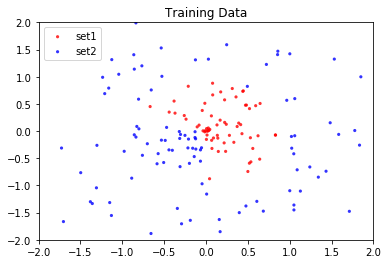

In [28]:
data = (set_1, set_2)
colors = ("red", "blue")
groups = ("set1", "set2")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, alpha="1.0")
for data, color, group in zip(data, colors, groups):
    x = data[0:,0]
    y = data[0:,1]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=10, label=group)
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
plt.title('Training Data')
plt.legend(loc=2)
plt.show()

The number of coefficient for a quartic polynomial is $15$, which is therefore our number of variables.

In [29]:
# Number of variables
nvar = 15

Both constraints in (\ref{prob}) are linear with respect to variable $a$. Use set_1 and set_2 to set linear coefficients for those constraints.

In [30]:
A_1 = np.zeros((set_1.shape[0], nvar))
A_2 = np.zeros((set_2.shape[0], nvar))

for i in range(set_1.shape[0]):
    counter = 0
    for j in range(5):
        for k in range(5-j):
            A_1[i,counter] = set_1[i,0]**j * set_1[i,1]**k
            counter = counter + 1
for i in range(set_2.shape[0]):
    counter = 0
    for j in range(5):
        for k in range(5-j):
            A_2[i,counter] = set_2[i,0]**j * set_2[i,1]**k
            counter = counter + 1

## Model our problem via CVXPY and solve

In [31]:
# Define decision variables
x = cvx.Variable(nvar)
# Define objective function
objective = cvx.Minimize(cvx.norm(x))
# Define constraints
constraint = [A_1*x <= -1.0, A_2*x >= 1.0]
# Define the entire problem
problem = cvx.Problem(objective, constraint)
# Solve, Bing!
problem.solve(solver='NAG', verbose=True)
# Save result
coef = x.value


 ------------------------------------------------
  E04PT, Interior point method for SOCP problems
 ------------------------------------------------

 Begin of Options
     Print File                    =                  -1     * U
     Print Level                   =                   2     * d
     Print Options                 =                 Yes     * d
     Print Solution                =                  No     * d
     Monitoring File               =                   6     * U
     Monitoring Level              =                   2     * U
     Socp Monitor Frequency        =                   0     * d

     Infinite Bound Size           =         1.00000E+20     * d
     Task                          =            Minimize     * d
     Stats Time                    =                  No     * d
     Time Limit                    =         1.00000E+06     * d

     Socp Iteration Limit          =                 100     * d
     Socp Max Iterative Refinement =             

## Visualize the classifier

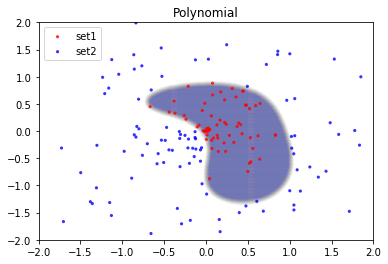

In [32]:
# Generate a mesh
x = np.arange(-5.0,5.0,0.008)
y = np.arange(-5.0,5.0,0.008)
xx, yy = np.meshgrid(x,y)

# Ploynomial value on the mesh
polyval = np.zeros(xx.shape)
counter = 0
for i in range(5):
    for j in range(5-i):
        polyval = polyval + coef[counter]*np.power(xx,i)*np.power(yy,j)
        counter = counter + 1

# Plot the trained polynomial
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, alpha="1.0")

ax.scatter(xx[polyval<=-1], yy[polyval<=-1], alpha=0.002)

data = (set_1, set_2)
colors = ("red", "blue")
groups = ("set1", "set2")
for data, color, group in zip(data, colors, groups):
    x = data[0:,0]
    y = data[0:,1]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=10, label=group)
plt.xlim(-2.0, 2.0)
plt.ylim(-2.0, 2.0)
plt.title('Polynomial')
plt.legend(loc=2)
plt.show()